In [1]:
import os
import numpy as np
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Veri Yolları
data_dir = "C:/Users/Mehmet Nur Kavan/Desktop/Medikal Görüntü İşleme Proje Veri Kümeleri/Medikal Görüntü İşleme Proje Veri Kümeleri/"
categories = ["akcigerCokmesiXr", "zatureXr", "veremXr", "saglikli"]

# Görüntü Boyutu ve Model Yolu
target_size = (128, 128)
model_path = "trained_lung_model.h5"

In [4]:
# Veri Yükleme ve Ayrım
def load_and_split_data(data_dir, categories, test_size=0.2):
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)
            try:
                img = Image.open(file_path).convert("RGB")
                img_resized = img.resize(target_size)
                images.append(np.array(img_resized))
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")
    
    images = np.array(images) / 255.0
    labels = np.array(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, stratify=labels, random_state=42)
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = load_and_split_data(data_dir, categories)

In [6]:
# Model Eğitimi
if not os.path.exists(model_path):
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Etiketleri One-Hot Encoding Formatına Çevir
    y_train_categorical = to_categorical(y_train, num_classes=len(categories))
    y_test_categorical = to_categorical(y_test, num_classes=len(categories))

    # Augmentation ve Normalizasyon
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True
    )
    train_generator = train_datagen.flow(X_train, y_train_categorical, batch_size=32)
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow(X_test, y_test_categorical, batch_size=32, shuffle=False)

    # MobileNetV2 Modeli
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(categories), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    # Modeli Eğit
    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=test_generator,
        callbacks=[early_stopping, reduce_lr]
    )
    model.save(model_path)
    print("Model eğitildi ve kaydedildi.")
else:
    model = load_model(model_path)
    print("Eğitilmiş model yüklendi.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


c:\Users\Mehmet Nur Kavan\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
659/659 ━━━━━━━━━━━━━━━━━━━━ 279s 406ms/step - accuracy: 0.6645 - loss: 4.2386 - val_accuracy: 0.7359 - val_loss: 2.1245 - learning_rate: 1.0000e-04
Epoch 2/15
659/659 ━━━━━━━━━━━━━━━━━━━━ 267s 405ms/step - accuracy: 0.7500 - loss: 1.9206 - val_accuracy: 0.7536 - val_loss: 1.3389 - learning_rate: 1.0000e-04
Epoch 3/15
659/659 ━━━━━━━━━━━━━━━━━━━━ 245s 371ms/step - accuracy: 0.7572 - loss: 1.2684 - val_accuracy: 0.7501 - val_loss: 1.0225 - learning_rate: 1.0000e-04
Epoch 4/15
659/659 ━━━━━━━━━━━━━━━━━━━━ 249s 378ms/step - accuracy: 0.7629 - loss: 0.9799 - val_accuracy: 0.7790 - val_loss: 0.7995 - learning_rate: 1.0000e-04
Epoch 5/15
659/659 ━━━━━━━━━━━━━━━━━━━━ 254s 385ms/step - accuracy: 0.7738 - loss: 0.8289 - val_accuracy: 0.7720 - val_loss: 0.7414 - learning_rate: 1.0000e-04
Epoch 6/15
659/659 ━━━━━━━━━━━━━━━━━━━━ 248s 377ms/step - accuracy: 0.7752 - loss: 0.7549 - val_accuracy: 0.7968 - val_loss: 0.6397 - learning_rate: 1.0000e-04
Epoch 7/15
659/659 ━━━━━━━━━━━━━━━━━━━━ 

Model eğitildi ve kaydedildi.


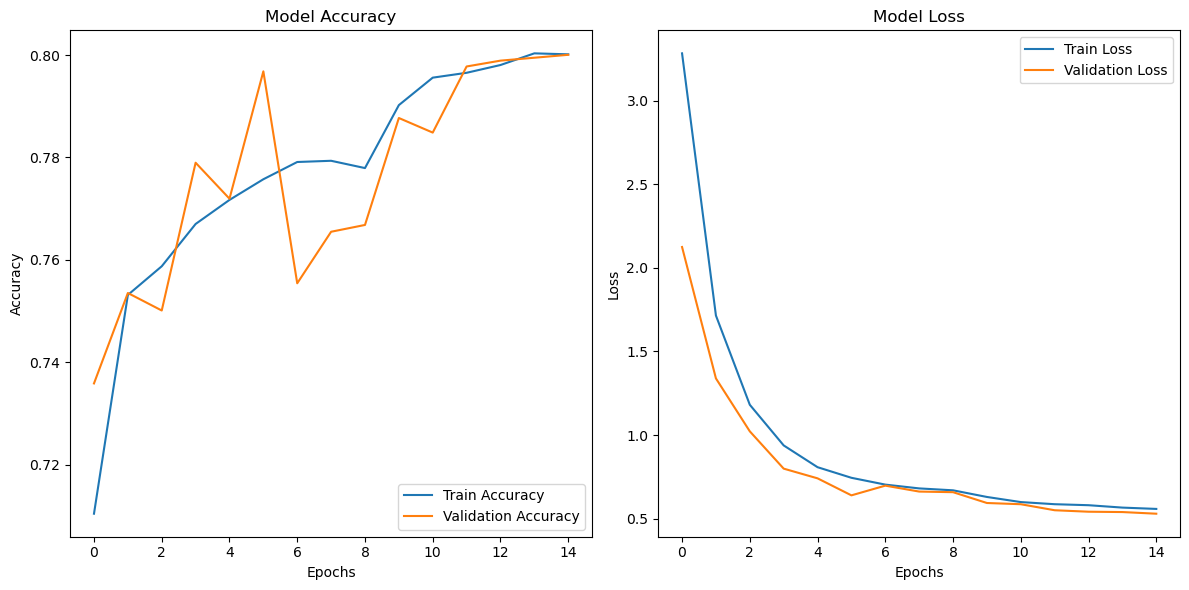

In [7]:
# Eğitim Süreci Grafikleri
if 'history' in locals() or 'history' in globals():
    plt.figure(figsize=(12, 6))

    # Doğruluk
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Kayıp
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
# Test Verisinde Tahmin
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

165/165 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step


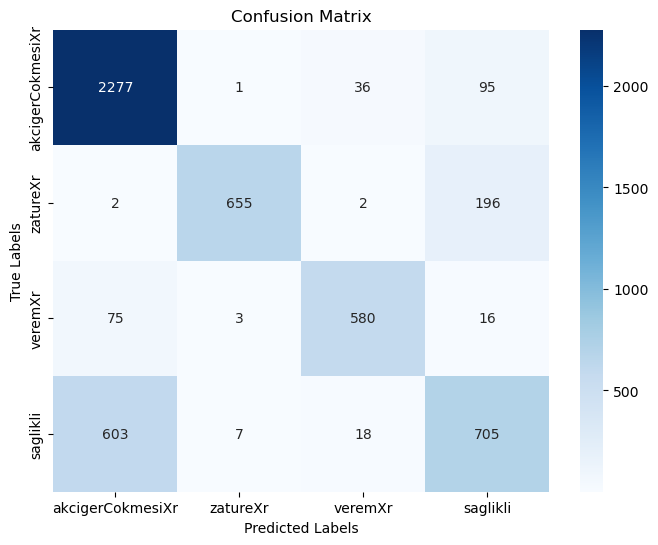

Classification Report:
                  precision    recall  f1-score   support

akcigerCokmesiXr       0.77      0.95      0.85      2409
        zatureXr       0.98      0.77      0.86       855
         veremXr       0.91      0.86      0.89       674
        saglikli       0.70      0.53      0.60      1333

        accuracy                           0.80      5271
       macro avg       0.84      0.78      0.80      5271
    weighted avg       0.80      0.80      0.79      5271



In [9]:
# Karmaşıklık Matrisi ve Sınıflandırma Raporu
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


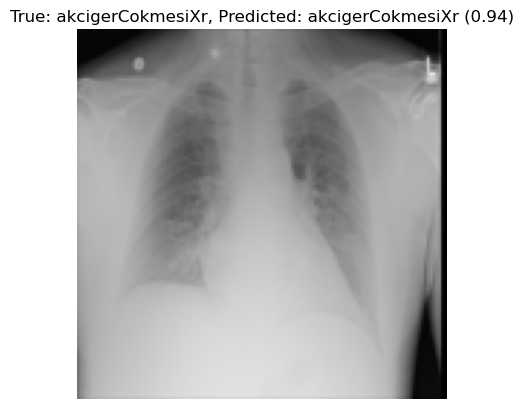

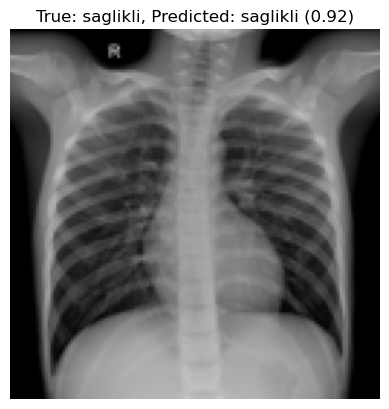

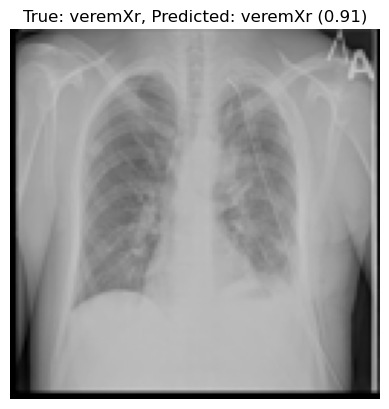

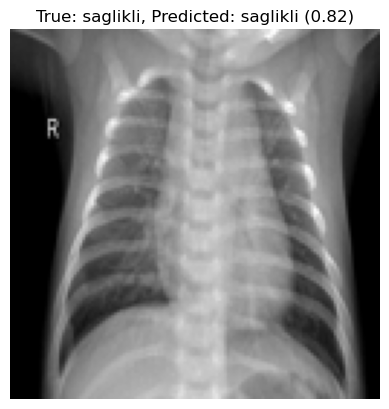

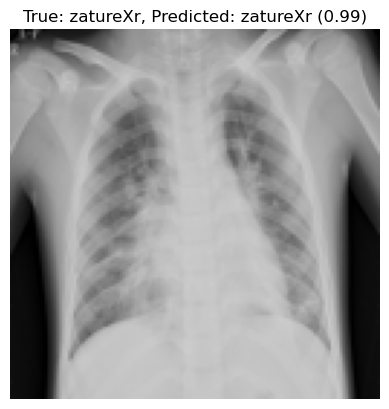

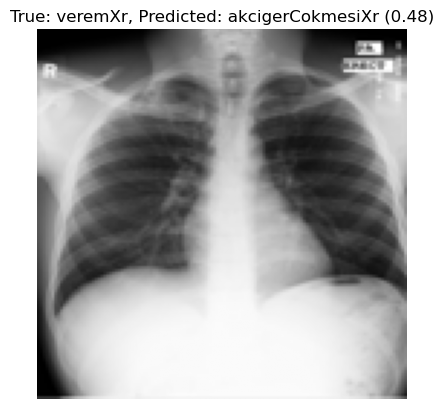

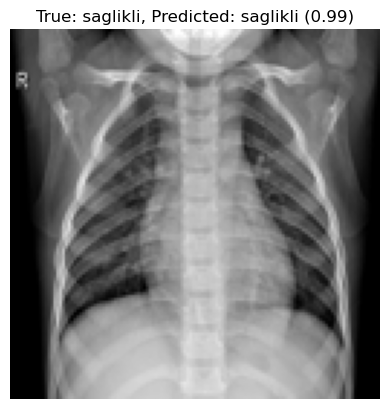

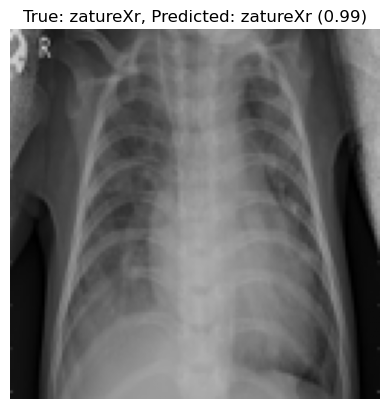

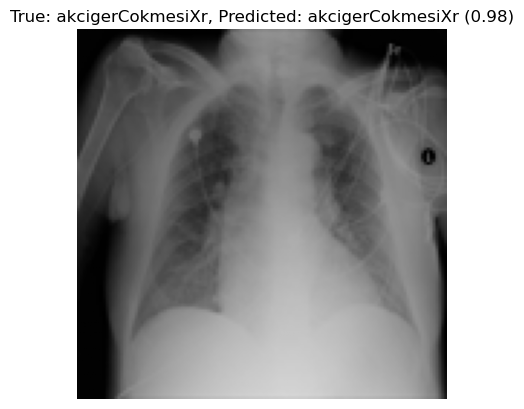

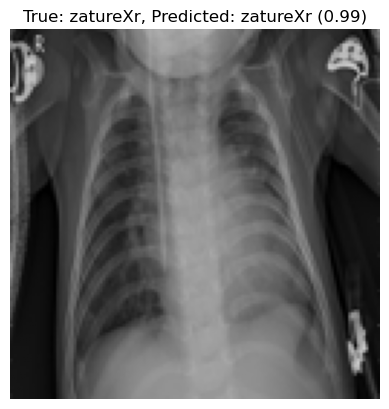

In [10]:
# Rastgele 10 Test Görüntüsü Tahmini ve Görselleştirme
def predict_and_show_images(model, X_test, y_test, categories, n_images=10):
    indices = random.sample(range(len(X_test)), n_images)
    images = X_test[indices]
    true_labels = y_test[indices]

    predictions = model.predict(images)
    for i, pred in enumerate(predictions):
        true_label = categories[true_labels[i]]
        pred_label = categories[np.argmax(pred)]
        confidence = np.max(pred)

        plt.figure()
        plt.imshow(images[i])
        plt.title(f"True: {true_label}, Predicted: {pred_label} ({confidence:.2f})")
        plt.axis('off')
        plt.show()

predict_and_show_images(model, X_test, y_test, categories)